# Demo of a decision tree Leo transpilation

## The three classes of the Iris dataset
![The three classes of the iris dataset](https://editor.analyticsvidhya.com/uploads/51518iris%20img1.png "The three classes of the iris dataset")

## Load the Iris dataset and explore the data

In [1]:
from sklearn.datasets import load_iris

# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# take a look at the data
print(f"Data shape: {X.shape}")
print(f"Feature names: {iris.feature_names}")
print(f"Label names: {iris.target_names}")
print(f"First row: {X[0]}")
print(f"First label: {y[0]}")

Data shape: (150, 4)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Label names: ['setosa' 'versicolor' 'virginica']
First row: [5.1 3.5 1.4 0.2]
First label: 0


## Split the dataset into a training and a test set, and train the classifier

In [2]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3]:
from sklearn.tree import DecisionTreeClassifier

# Create and train a decision tree classifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

## Visualize the decision tree

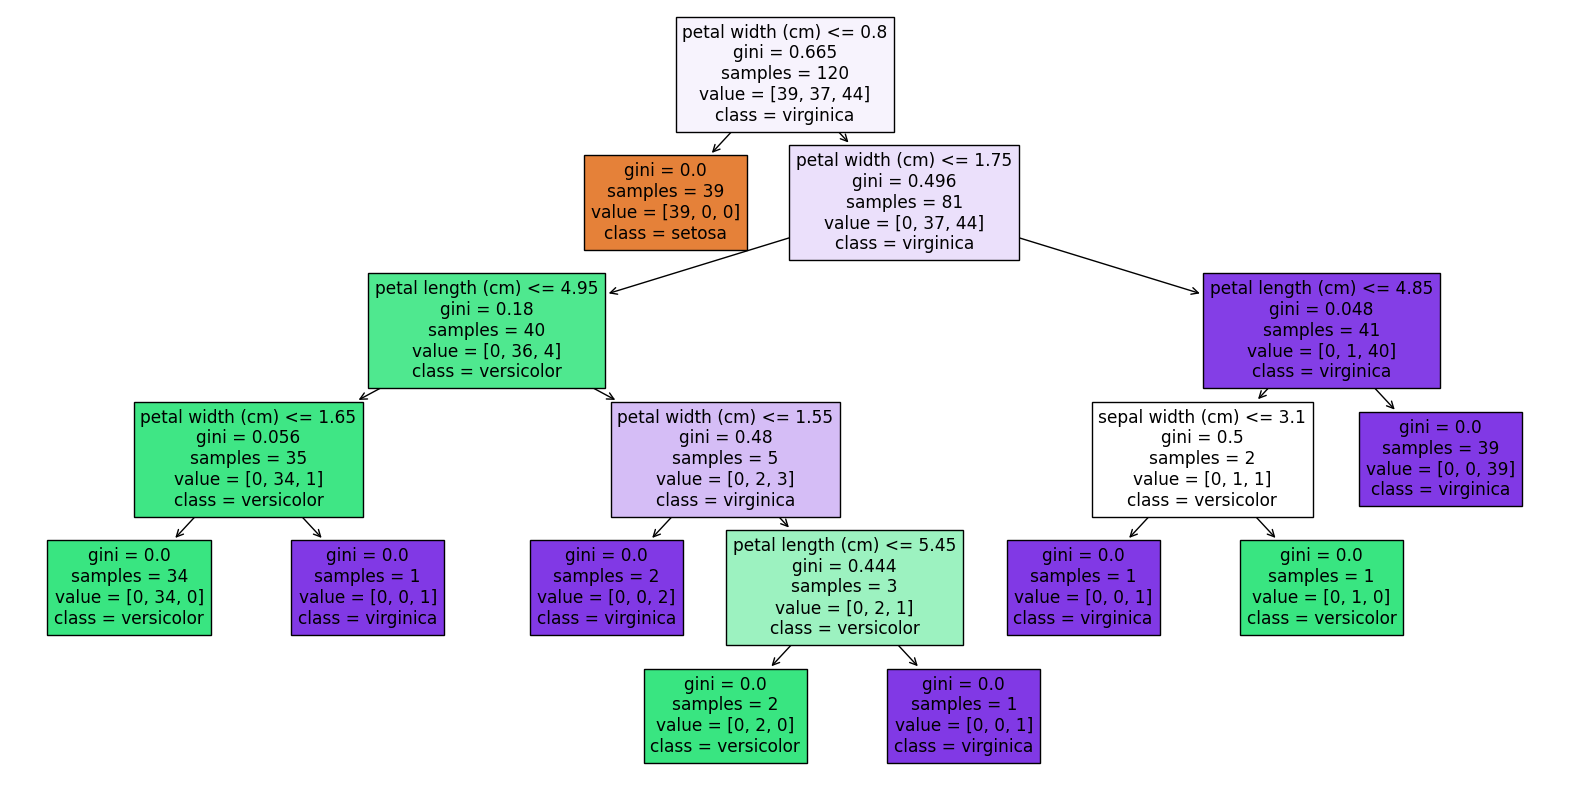

In [4]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    filled=True,
    feature_names=iris.feature_names,
    class_names=iris.target_names.tolist(),
)
plt.show()

## Transpile the model into Leo code

In [5]:
import os

from leotranspiler.leo_transpiler import LeoTranspiler

# Transpile the deceision tree into Leo code
lt = LeoTranspiler(model=clf, validation_data=X_train)
leo_project_path = os.path.join(os.getcwd(), "tmp")
leo_project_name = "tree1"
lt.to_leo(path=leo_project_path, project_name=leo_project_name)

Computing number ranges and fixed-point scaling factor...
Minimum number: -2.0, maximum number: 7.9. Recommended fixed-point scaling factor: 128, required Leo type: i16
Transpiling model...
Leo program stored


## Let's take a look at the transpiled Leo code
(the thresholds in the conditions are going to be different compared to the visual representation because of the fixed-point conversion)

In [6]:
# take a look at the transpiled code
leo_code_path = os.path.join(
    (os.path.join(leo_project_path, leo_project_name, "src", "main.leo"))
)
with open(leo_code_path, "r") as f:
    leo_code = f.read()
print(leo_code)

// This file was automatically generated by the LeoTranspiler.
program tree1.aleo {
    transition main (x1: i16, x2: i16, x3: i16) -> (i16) {
        if x3 <= 102i16 {
            return 0i16;
        }
        else {
            if x3 <= 224i16 {
                if x2 <= 633i16 {
                    if x3 <= 211i16 {
                        return 128i16;
                    }
                    else {
                        return 256i16;
                    }
                }
                else {
                    if x3 <= 198i16 {
                        return 256i16;
                    }
                    else {
                        if x2 <= 697i16 {
                            return 128i16;
                        }
                        else {
                            return 256i16;
                        }
                    }
                }
            }
            else {
                if x2 <= 620i16 {
                    if x1 <= 396i16 {
       

## Let's input one test data instance into the Leo and Python model and compare the predictions and labels

In [7]:
# prove and compare the Leo prediction with the Python prediction and the label
zkp = lt.execute(input_sample=X_test[0])
python_prediction = clf.predict([X_test[0]])

print(f"Circuit constraints: {zkp.circuit_constraints}")
print(f"Leo prediction in fixed-point notation: {zkp.output[0]}")
print(f"Leo prediction in decimal notation: {zkp.output_decimal[0]}")
print(f"Python prediction: {python_prediction[0]}")
print(f"Label: {y_test[0]}")
print(f"Proof: {zkp.proof}")

Circuit constraints: 189
Leo prediction in fixed-point notation: 256
Leo prediction in decimal notation: 2.0
Python prediction: 2
Label: 2
Proof: proof1qqqsqqqqqqqqqqqpqqqqqqqqqqqqj3jzadcsxlr353ydewnqk448pquhwz97rk0ruwvux49yzl74mjk703vxwths8dy4rmddhgxc3xypw7k794q4ju9pcn7vusp09a0gyccpyuxjqx7mzmpmca8q2es386zmqrpf8jwzzmgqn58zt6aqt4wcrsvmsn76jhghfqpydn6gksf6lgjrxd00s2fp9afz7y9tf8v47axv7c8snwgu90ehr8yd6h0ds6s5syq6xmpdpnpa03kmh988w338z2848a9dc2zys888pc8jakkefvf7tyhstk805ejnlyllctmwccj3mgyp8jld27765lu6qn6uksn97tpusltt53mjppqdam4cs7h5wqtmmqh4duqnz4k09wnt4fnvkghv3k6spmxrd3ygpsk4eft3dkcr5xghh0httzcswq29k3m5mlde8qk46qtlkzu5txvdz0hy0pmrdgh6h9faszwf5yvna7zzshdtnh43v8yuy36ckz5tl4zjfyyqy5l7ap6gfnz2fqcdrhg6hmrht6vcf6n6ha5slqpsuypjf8kqlf2pxdy5dfrkk729pa704lwzzrv3vq0zukddk68qswmzzl0hn467hv2g66csekrt2kqzng7u73d3748jd5sa2enl02kz4amwr4f534mdlxh4jwlgl2gxhz8yhkyllxlc4z3ets3phskvzyvp4pk27vglp96gsh05qjt6y3wcup86q4jka836zwvl5jxmncw49c9kspawrv50eu3z3h54tgdazalqrvjl6m3qps6jk98wju95wdvjpzw4te0qqheh332w6s6my8xjcfcr

## Let's compare the classification accuracy for the Leo and Python model over the entire test data set 

In [8]:
import numpy as np

# Compute the accuracy of the Leo program and the Python program on the test set
num_test_samples = len(X_test)
leo_predictions = np.zeros(num_test_samples)
for i in range(num_test_samples):
    leo_predictions[i] = lt.run(input_sample=X_test[i]).output_decimal[0]

python_predictions = clf.predict(X_test)

leo_accuracy = np.sum(leo_predictions == y_test) / num_test_samples
python_accuracy = np.sum(python_predictions == y_test) / num_test_samples

print(f"Leo accuracy: {100*leo_accuracy} %")
print(f"Python accuracy: {100*python_accuracy} %")

Leo accuracy: 100.0 %
Python accuracy: 100.0 %
